# Extract aperiodic component of Sleep Data 

This script loads the pre-processed polysomnography data and extracts the apeiodic component of the EEG signal using the fooof algorithm (https://github.com/fooof-tools/fooof) and the IRASA algorithm (https://doi.org/10.1007/s10548-015-0448-0). The aperiodic component is then saved as a .csv file along with other spectrally derived information and specifically utilized parameters. 

In [151]:
%matplotlib inline

## Import packages 
import yasa
import pickle
from collections import ChainMap
from fooof import FOOOF
from fooof.objs.utils import average_fg, combine_fooofs, compare_info
from fooof.bands import Bands
import numpy as np
import os
import mne
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal 
import scipy.stats as stats
mne.set_log_level('WARNING')

# Set plotting settings
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('colorblind')

In [2]:
## Adjusted YASA functions for computing aperiodic power spectrum based on IRASA method

def irasa(data, sf=None, ch_names=None, band=(1, 45),
          hset=[1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5,
                1.55,1.6,1.65,1.7,1.75,1.8,1.85,1.9],
          return_fit=True,
          win_sec=4,
          kwargs_welch=dict(average="median", window="hamming"),
          verbose=True,
          ):
    """
    Separate the aperiodic (= fractal, or 1/f) and oscillatory component
    of the power spectra of EEG data using the IRASA method.

    .. versionadded:: 0.1.7

    Parameters
    ----------
    data : :py:class:`numpy.ndarray` or :py:class:`mne.io.BaseRaw`
        1D or 2D EEG data. Can also be a :py:class:`mne.io.BaseRaw`, in which
        case ``data``, ``sf``, and ``ch_names`` will be automatically
        extracted, and ``data`` will also be converted from Volts (MNE default)
        to micro-Volts (YASA).
    sf : float
        The sampling frequency of data AND the hypnogram.
        Can be omitted if ``data`` is a :py:class:`mne.io.BaseRaw`.
    ch_names : list
        List of channel names, e.g. ['Cz', 'F3', 'F4', ...]. If None,
        channels will be labelled ['CHAN000', 'CHAN001', ...].
        Can be omitted if ``data`` is a :py:class:`mne.io.BaseRaw`.
    band : tuple or None
        Broad band frequency range.
        Default is 1 to 30 Hz.
    hset : list or :py:class:`numpy.ndarray`
        Resampling factors used in IRASA calculation. Default is to use a range
        of values from 1.1 to 1.9 with an increment of 0.05.
    return_fit : boolean
        If True (default), fit an exponential function to the aperiodic PSD
        and return the fit parameters (intercept, slope) and :math:`R^2` of
        the fit.

        The aperiodic signal, :math:`L`, is modeled using an exponential
        function in semilog-power space (linear frequencies and log PSD) as:

        .. math:: L = a + \text{log}(F^b)

        where :math:`a` is the intercept, :math:`b` is the slope, and
        :math:`F` the vector of input frequencies.
    win_sec : int or float
        The length of the sliding window, in seconds, used for the Welch PSD
        calculation. Ideally, this should be at least two times the inverse of
        the lower frequency of interest (e.g. for a lower frequency of interest
        of 0.5 Hz, the window length should be at least 2 * 1 / 0.5 =
        4 seconds).
    kwargs_welch : dict
        Optional keywords arguments that are passed to the
        :py:func:`scipy.signal.welch` function.
    verbose : bool or str
        Verbose level. Default (False) will only print warning and error
        messages. The logging levels are 'debug', 'info', 'warning', 'error',
        and 'critical'. For most users the choice is between 'info'
        (or ``verbose=True``) and warning (``verbose=False``).

    Returns
    -------
    freqs : :py:class:`numpy.ndarray`
        Frequency vector.
    psd_aperiodic : :py:class:`numpy.ndarray`
        The fractal (= aperiodic) component of the PSD.
    psd_oscillatory : :py:class:`numpy.ndarray`
        The oscillatory (= periodic) component of the PSD.
    fit_params : :py:class:`pandas.DataFrame` (optional)
        Dataframe of fit parameters. Only if ``return_fit=True``.

    Notes
    -----
    The Irregular-Resampling Auto-Spectral Analysis (IRASA) method is
    described in Wen & Liu (2016). In a nutshell, the goal is to separate the
    fractal and oscillatory components in the power spectrum of EEG signals.

    The steps are:

    1. Compute the original power spectral density (PSD) using Welch's method.
    2. Resample the EEG data by multiple non-integer factors and their
       reciprocals (:math:`h` and :math:`1/h`).
    3. For every pair of resampled signals, calculate the PSD and take the
       geometric mean of both. In the resulting PSD, the power associated with
       the oscillatory component is redistributed away from its original
       (fundamental and harmonic) frequencies by a frequency offset that varies
       with the resampling factor, whereas the power solely attributed to the
       fractal component remains the same power-law statistical distribution
       independent of the resampling factor.
    4. It follows that taking the median of the PSD of the variously
       resampled signals can extract the power spectrum of the fractal
       component, and the difference between the original power spectrum and
       the extracted fractal spectrum offers an approximate estimate of the
       power spectrum of the oscillatory component.

    Note that an estimate of the original PSD can be calculated by simply
    adding ``psd = psd_aperiodic + psd_oscillatory``.

    For an example of how to use this function, please refer to
    https://github.com/raphaelvallat/yasa/blob/master/notebooks/09_IRASA.ipynb

    For an article discussing the challenges of using IRASA (or fooof) see [5].

    References
    ----------
    [1] Wen, H., & Liu, Z. (2016). Separating Fractal and Oscillatory
        Components in the Power Spectrum of Neurophysiological Signal.
        Brain Topography, 29(1), 13–26.
        https://doi.org/10.1007/s10548-015-0448-0

    [2] https://github.com/fieldtrip/fieldtrip/blob/master/specest/

    [3] https://github.com/fooof-tools/fooof

    [4] https://www.biorxiv.org/content/10.1101/299859v1

    [5] https://doi.org/10.1101/2021.10.15.464483
    """
    import fractions
    from yasa.io import set_log_level
    import logging

    set_log_level(verbose)
    # Check if input data is a MNE Raw object
    if isinstance(data, mne.io.BaseRaw):
        sf = data.info["sfreq"]  # Extract sampling frequency
        ch_names = data.ch_names  # Extract channel names
        hp = data.info["highpass"]  # Extract highpass filter
        lp = data.info["lowpass"]  # Extract lowpass filter
        data = data.get_data(units=dict(eeg="uV", emg="uV", eog="uV", ecg="uV"))
    else:
        # Safety checks
        assert isinstance(data, np.ndarray), "Data must be a numpy array."
        data = np.atleast_2d(data)
        assert data.ndim == 2, "Data must be of shape (nchan, n_samples)."
        nchan, npts = data.shape
        assert nchan < npts, "Data must be of shape (nchan, n_samples)."
        assert sf is not None, "sf must be specified if passing a numpy array."
        assert isinstance(sf, (int, float))
        if ch_names is None:
            ch_names = ["CHAN" + str(i).zfill(3) for i in range(nchan)]
        else:
            ch_names = np.atleast_1d(np.asarray(ch_names, dtype=str))
            assert ch_names.ndim == 1, "ch_names must be 1D."
            assert len(ch_names) == nchan, "ch_names must match data.shape[0]."
        hp = 0  # Highpass filter unknown -> set to 0 Hz
        lp = sf / 2  # Lowpass filter unknown -> set to Nyquist

    # Check the other arguments
    hset = np.asarray(hset)
    assert hset.ndim == 1, "hset must be 1D."
    assert hset.size > 1, "2 or more resampling fators are required."
    hset = np.round(hset, 4)  # avoid float precision error with np.arange.
    band = sorted(band)
    assert band[0] > 0, "first element of band must be > 0."
    assert band[1] < (sf / 2), "second element of band must be < (sf / 2)."
    win = int(win_sec * sf)  # nperseg

    # Inform about maximum resampled fitting range
    h_max = np.max(hset)
    band_evaluated = (band[0] / h_max, band[1] * h_max)
    freq_Nyq = sf / 2  # Nyquist frequency
    freq_Nyq_res = freq_Nyq / h_max  # minimum resampled Nyquist frequency
    logging.info(f"Fitting range: {band[0]:.2f}Hz-{band[1]:.2f}Hz")
    logging.info(f"Evaluated frequency range: {band_evaluated[0]:.2f}Hz-{band_evaluated[1]:.2f}Hz")
    if band_evaluated[0] < hp:
        logging.warning(
            "The evaluated frequency range starts below the "
            f"highpass filter ({hp:.2f}Hz). Increase the lower band"
            f" ({band[0]:.2f}Hz) or decrease the maximum value of "
            f"the hset ({h_max:.2f})."
        )
    if band_evaluated[1] > lp and lp < freq_Nyq_res:
        logging.warning(
            "The evaluated frequency range ends after the "
            f"lowpass filter ({lp:.2f}Hz). Decrease the upper band"
            f" ({band[1]:.2f}Hz) or decrease the maximum value of "
            f"the hset ({h_max:.2f})."
        )
    if band_evaluated[1] > freq_Nyq_res:
        logging.warning(
            "The evaluated frequency range ends after the "
            "resampled Nyquist frequency "
            f"({freq_Nyq_res:.2f}Hz). Decrease the upper band "
            f"({band[1]:.2f}Hz) or decrease the maximum value "
            f"of the hset ({h_max:.2f})."
        )

    # Calculate the original PSD over the whole data
    freqs, psd = signal.welch(data, sf, nperseg=win, **kwargs_welch)

    # Start the IRASA procedure
    psds = np.zeros((len(hset), *psd.shape))

    for i, h in enumerate(hset):
        # Get the upsampling/downsampling (h, 1/h) factors as integer
        rat = fractions.Fraction(str(h))
        up, down = rat.numerator, rat.denominator
        # Much faster than FFT-based resampling
        data_up = signal.resample_poly(data, up, down, axis=-1)
        data_down = signal.resample_poly(data, down, up, axis=-1)
        # Calculate the PSD using same params as original
        freqs_up, psd_up = signal.welch(data_up, h * sf, nperseg=win, **kwargs_welch)
        freqs_dw, psd_dw = signal.welch(data_down, sf / h, nperseg=win, **kwargs_welch)
        # Geometric mean of h and 1/h
        psds[i, :] = np.sqrt(psd_up * psd_dw)

    # Now we take the median PSD of all the resampling factors, which gives
    # a good estimate of the aperiodic component of the PSD.
    psd_aperiodic = np.median(psds, axis=0)

    # We can now calculate the oscillations (= periodic) component.
    psd_osc = psd - psd_aperiodic

    # Let's crop to the frequencies defined in band
    mask_freqs = np.ma.masked_outside(freqs, *band).mask
    freqs = freqs[~mask_freqs]
    psd_aperiodic = np.compress(~mask_freqs, psd_aperiodic, axis=-1)
    psd_osc = np.compress(~mask_freqs, psd_osc, axis=-1)

    if return_fit:
        # Aperiodic fit in semilog space for each channel
        from scipy.optimize import curve_fit

        intercepts, slopes, r_squared = [], [], []

        def func(t, a, b):
            # See https://github.com/fooof-tools/fooof
            return a + np.log10(t**b)

        for y in np.atleast_2d(psd_aperiodic):
            y_log = np.log10(y)
            # Note that here we define bounds for the slope but not for the
            # intercept.
            popt, pcov = curve_fit(
                func, freqs, y_log, p0=(2, -1), bounds=((-np.inf, -10), (np.inf, 2))
            )
            intercepts.append(popt[0])
            slopes.append(popt[1])
            # Calculate R^2: https://stackoverflow.com/q/19189362/10581531
            residuals = y_log - func(freqs, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y_log - np.mean(y_log)) ** 2)
            r_squared.append(1 - (ss_res / ss_tot))

        # Create fit parameters dataframe
        fit_params = {
            "Chan": ch_names,
            "Intercept": intercepts,
            "Slope": slopes,
            "R^2": r_squared,
            "std(osc)": np.std(psd_osc, axis=-1, ddof=1),
        }
        return freqs, psd_aperiodic, psd_osc, pd.DataFrame(fit_params)
    else:
        return freqs, psd_aperiodic, psd_osc

def compute_irasa_power(data, hypnogram, sf, subject, band=(1, 45), h_set_max=1.5):
    """
    Compute the IRASA power spectrum for each sleep stage.

    Parameters:
    -----------
    data : ndarray
        2D EEG data where columns represent time points and rows represent different channels.
    hypnogram : ndarray
        1D array representing the sleep stage for each time point in data.
    sf : float
        Sampling frequency of the EEG data.
    subject : str
        Identifier for the subject whose data is being processed.
    band : tuple
        Frequency band to compute the IRASA power spectrum over.

    Returns:
    --------
    fit_df : DataFrame
        A DataFrame containing fit parameters for each sleep stage.
    psd_df : DataFrame
        A DataFrame containing power spectral density values for each sleep stage.

    Notes:
    ------
    This function uses the YASA library's IRASA method to separate oscillatory and aperiodic components 
    of the EEG power spectrum for each sleep stage. It then computes bandpower for each component and optionally
    plots the PSD for each component.
    """

    fit_dfs = []
    psd_aperiodic_dict = {}
    psd_oscillatory_dict = {}
    
    for stage in np.unique(hypnogram):
        if stage >= 0:
            stage_data = data[:, hypnogram == int(stage)]

            # Extract aperiodic and oscillatory components of the PSD
            freqs, psd_aperiodic, psd_oscillatory, fit_params = irasa( # type: ignore
                stage_data, sf=sf, ch_names=['C3', 'C4'], band=band,
                return_fit=True, win_sec=2,
                hset=np.arange(1.0, h_set_max + 0.05, 0.05),
                kwargs_welch=dict(average='median', window='hamming')
            )
            fit_params['Stage'] = stage
            fit_params['Subject'] = subject
            fit_dfs.append(fit_params)

            for idx, channel in enumerate(['C3', 'C4']):
                key = (stage, channel)
                psd_aperiodic_dict[key] = psd_aperiodic[idx, :]
                psd_oscillatory_dict[key] = psd_oscillatory[idx, :]
            
    fit_df = pd.concat(fit_dfs, axis=0)

    return freqs, psd_aperiodic_dict, psd_oscillatory_dict, fit_df.reset_index(drop=True)

## Plotting function for spectral components for both IRASA and FOOOF

def plot_spectral_components(freqs=None, psd_osc=None, psd_ap=None, fm=None, chan=None, 
                             stage=None, fit_params=None, log_freq=True, method='IRASA',
                             save=False, fig_path=None):
    if method == 'FOOOF':
        # Plot FOOOF results
        fig = plt.figure() 
        plt.tight_layout()
        plt.yscale('log')
        if log_freq:
            plt.xscale('log')
        plt.plot(fm.freqs, 10**(fm.power_spectrum), c='k', label="Power spectrum", lw=2)
        plt.plot(fm.freqs, 10**(fm._ap_fit), c='b',linestyle='--', label="Aperiodic fit", lw=2)
        plt.plot(fm.freqs, 10**(fm.fooofed_spectrum_), c='r', label="FOOOF model fit", lw=2)
        fig.suptitle('Full signal PSD with FOOOF result')
        fig.axes[0].set_xlabel("Frequency (Hz)")
        fig.axes[0].set_ylabel("PSD log($V^2$/Hz)")
        fig.axes[0].legend()
        # set text with fit parameters
        fig.axes[0].text(0.1, 0.5, f"Slope: {round(fm.aperiodic_params_[1], 2)}", 
                         transform=fig.axes[0].transAxes)
        sns.despine()

    elif method == 'IRASA':
        # Plot IRASA results
        fig = plt.figure() 
        plt.tight_layout()
        plt.yscale('log')
        if log_freq:
            plt.xscale('log')
        plt.plot(freqs, (psd_ap+psd_osc).ravel(), c='k', label="Power spectrum", lw=2)
        plt.plot(freqs, psd_ap.ravel(), c='b',linestyle='--', label="Aperiodic fit", lw=2)
        #plt.plot(freqs, psd_osc.ravel(), c='cyan',linestyle='--', label="Periodic components", lw=2)
        fig.suptitle('Full signal PSD with IRASA result')
        fig.axes[0].set_xlabel("Frequency (Hz)")
        fig.axes[0].set_ylabel("PSD log($V^2$/Hz)")
        fig.axes[0].legend()
        # set text with fit parameters 
        slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope']
        fig.axes[0].text(0.1, 0.5, f"Slope: {round(slope,2)}",
                         transform=fig.axes[0].transAxes)    
        sns.despine()   

    if save:
        plt.savefig(f'{fig_path}.png')
        plt.close('all')

    return fig

## Function to compute the aperiodic exponent with FOOOF for each sleep stage for channels C3 and C4

def compute_fooof_aperiodic_exponent(data, sf, hypnogram, subject, band=(1, 45)):
    aperiodic_exponent_dfs = []
    fg_dict = {}

    # Compute the power spectrum for each sleep stage
    for stage in np.unique(hypnogram):
        if stage >= 0:
            # Slice the data based on sleep stage
            stage_data = data[:, hypnogram == stage]
            # Slice the data based on channel
            for idx, ch_name in enumerate(['C3', 'C4']):
                # Initialize FOOOF object for each channel-stage combination
                fg = FOOOF(max_n_peaks=5, aperiodic_mode='fixed', peak_width_limits=(0.5, 12.0), 
                           min_peak_height=0.0, peak_threshold=2.0, verbose=False)
                
                # Compute the power spectrum
                freqs, psd = signal.welch(stage_data[idx, :], sf, nperseg=int(2*sf), 
                                          average='median', window='hamming')
                freqs_foi = freqs[(freqs >= band[0]) & (freqs <= band[1])]
                psd_foi = psd[(freqs >= band[0]) & (freqs <= band[1])]
                
                # Fit the FOOOF model
                fg.fit(freqs, psd, freq_range=band)
                
                # Store the FOOOF object to dictionary
                key = (stage, ch_name)
                fg_dict[key] = fg
                
                # Extract the aperiodic exponent
                aperiodic_exponent = fg.get_params('aperiodic_params', 'exponent')
                
                # Extract the R^2 value
                r2s = fg.get_params('r_squared')
                
                # Extract the intercept
                intercept = fg.get_params('aperiodic_params', 'offset')
                
                # Extract the standard deviation of the oscillatory component
                std_osc = np.std(fg.power_spectrum - fg._ap_fit, ddof=1, axis=-1)
                
                # Store the aperiodic exponent
                aperiodic_exponent_df = pd.DataFrame({
                    'Subject': [subject]*len(freqs_foi),
                    'Stage': [stage]*len(freqs_foi),
                    'Chan': [ch_name]*len(freqs_foi),
                    'Slope': [aperiodic_exponent]*len(freqs_foi),
                    'R^2': [r2s]*len(freqs_foi), 
                    'Intercept': [intercept]*len(freqs_foi),
                    'std(osc)': [std_osc]*len(freqs_foi),
                    'Spectrum': psd_foi,
                    'Frequency': freqs_foi
                })
                aperiodic_exponent_dfs.append(aperiodic_exponent_df)

    # Combine all dataframes
    aperiodic_exponent_df_all = pd.concat(aperiodic_exponent_dfs, axis=0)

    return fg_dict, aperiodic_exponent_df_all.reset_index(drop=True)
    

## 1. Load data

In [3]:
# Set paths
path = '/mnt/server/data03/2023_NENA_Aperiodic_Workshop/data/processed/'
fig_path = '/mnt/server/data03/2023_NENA_Aperiodic_Workshop/figures/subject/'
# Obtain list of unique recordings
files = list(set(["-".join(f.split('-')[0:3]) for f in os.listdir(path)]))

## 2. Process and extract aperiodic component from recording files

In [4]:
## Iterate over all files and process them
fit_dfs, fooof_dfs, psd_aperiodic_all, psd_oscillatory_all, fooof_groups_all = [], [], [], [], []
for idx, file in enumerate(tqdm(files)):
    print(f'Extracting aperiodic components from file : {file}')
    # Load the data and hypnogram files
    subject = file.split('-')[-1]
    raw = mne.io.read_raw_fif(path + file + '-raw.fif.gz', preload=True)
    hypnogram = np.load(path + file + '-hypnogram_with_art.npy')
    # Get sampling frequency
    sf = raw.info['sfreq']
    # Get data
    data = raw.get_data(['C3','C4'], units='uV') 
    # Extract aperiodic component with IRASA from yasa per sleep stage
    freqs, psd_aperiodic, psd_oscillatory, fit_df = compute_irasa_power(data, hypnogram, sf, subject, band=(1, 45), h_set_max=1.5)
    fit_df['Method'] = 'IRASA'
    fit_dfs.append(fit_df)
    psd_aperiodic_all.append(psd_aperiodic)
    psd_oscillatory_all.append(psd_oscillatory)
    # Extract aperiodic component with FOOOF per sleep stage
    fg, fooof_df = compute_fooof_aperiodic_exponent(data, sf, hypnogram, subject, band=(1, 45))
    fooof_df['Method'] = 'FOOOF'   
    fooof_dfs.append(fooof_df)
    fooof_groups_all.append(fg)
    # Plot spectral results with IRASA and FOOOF
    for chan in ['C3', 'C4']:
        for stage in [0, 1, 2, 3, 4]:
            save_path = fig_path + f'{subject}_{stage}_{chan}'
            try:
                fig = plot_spectral_components(fm=fg[(stage, chan)], log_freq=True, method='FOOOF', 
                                            save=True, fig_path=save_path + '_FOOOF')
                fig2 = plot_spectral_components(freqs=freqs, psd_osc=psd_oscillatory[(stage, chan)], fit_params=fit_df,
                                                psd_ap=psd_aperiodic[(stage, chan)], log_freq=True, chan=chan, stage=stage,
                                                method='IRASA', save=True, fig_path=save_path + '_IRASA')
            except:
                print(f'No stage {stage} for {chan} for {subject}')
                pass
            
    # Testing break
    #if idx == 2:
    #    break

# Combine all dataframes
fit_df_all = pd.concat(fit_dfs, axis=0)
fooof_df_all = pd.concat(fooof_dfs, axis=0)
# Combine dictionaries
#psd_aperiodic_all_dict = ChainMap(psd_aperiodic_all)
#psd_oscillatory_all_dict = ChainMap(psd_oscillatory_all) 
#fooof_groups_all_dict = ChainMap(fooof_groups_all)

  0%|          | 0/50 [00:00<?, ?it/s]

Extracting aperiodic components from file : cfs-visit5-802709


  2%|▏         | 1/50 [01:27<1:11:35, 87.66s/it]

Extracting aperiodic components from file : cfs-visit5-801380


  4%|▍         | 2/50 [02:46<1:06:08, 82.68s/it]

Extracting aperiodic components from file : cfs-visit5-800092


  6%|▌         | 3/50 [04:09<1:04:50, 82.79s/it]

Extracting aperiodic components from file : cfs-visit5-802125


  8%|▊         | 4/50 [05:34<1:04:04, 83.57s/it]

Extracting aperiodic components from file : cfs-visit5-800184


 10%|█         | 5/50 [06:47<59:52, 79.83s/it]  

Extracting aperiodic components from file : cfs-visit5-802635


 12%|█▏        | 6/50 [08:06<58:21, 79.58s/it]

Extracting aperiodic components from file : cfs-visit5-800249


 14%|█▍        | 7/50 [09:26<57:01, 79.58s/it]

Extracting aperiodic components from file : cfs-visit5-800243


 16%|█▌        | 8/50 [10:50<56:41, 81.00s/it]

Extracting aperiodic components from file : cfs-visit5-802739


 18%|█▊        | 9/50 [12:12<55:30, 81.23s/it]

Extracting aperiodic components from file : cfs-visit5-800347


 20%|██        | 10/50 [13:28<53:06, 79.66s/it]

Extracting aperiodic components from file : cfs-visit5-800212


 22%|██▏       | 11/50 [14:50<52:20, 80.53s/it]

Extracting aperiodic components from file : cfs-visit5-801907


 24%|██▍       | 12/50 [16:11<51:04, 80.64s/it]

Extracting aperiodic components from file : cfs-visit5-801747


 26%|██▌       | 13/50 [17:30<49:18, 79.95s/it]

Extracting aperiodic components from file : cfs-visit5-802380


 28%|██▊       | 14/50 [18:51<48:13, 80.38s/it]

Extracting aperiodic components from file : cfs-visit5-801393


 30%|███       | 15/50 [20:07<46:10, 79.17s/it]

Extracting aperiodic components from file : cfs-visit5-802491


 32%|███▏      | 16/50 [21:31<45:39, 80.58s/it]

Extracting aperiodic components from file : cfs-visit5-801152


 34%|███▍      | 17/50 [22:51<44:11, 80.36s/it]

Extracting aperiodic components from file : cfs-visit5-801291


 36%|███▌      | 18/50 [24:18<43:54, 82.34s/it]

Extracting aperiodic components from file : cfs-visit5-800331


 38%|███▊      | 19/50 [25:27<40:28, 78.34s/it]

Extracting aperiodic components from file : cfs-visit5-802643


 40%|████      | 20/50 [26:47<39:28, 78.95s/it]

Extracting aperiodic components from file : cfs-visit5-801825


 42%|████▏     | 21/50 [28:05<38:01, 78.66s/it]

Extracting aperiodic components from file : cfs-visit5-802487


 44%|████▍     | 22/50 [29:25<36:54, 79.10s/it]

Extracting aperiodic components from file : cfs-visit5-801602


 46%|████▌     | 23/50 [30:47<35:58, 79.93s/it]

Extracting aperiodic components from file : cfs-visit5-800625


 48%|████▊     | 24/50 [32:03<34:07, 78.77s/it]

Extracting aperiodic components from file : cfs-visit5-800494


 50%|█████     | 25/50 [33:30<33:44, 81.00s/it]

Extracting aperiodic components from file : cfs-visit5-800630


 52%|█████▏    | 26/50 [34:57<33:11, 82.98s/it]

Extracting aperiodic components from file : cfs-visit5-801497


 54%|█████▍    | 27/50 [36:16<31:21, 81.79s/it]

Extracting aperiodic components from file : cfs-visit5-801058


 56%|█████▌    | 28/50 [37:38<29:56, 81.65s/it]

Extracting aperiodic components from file : cfs-visit5-801323


 58%|█████▊    | 29/50 [38:51<27:44, 79.27s/it]

Extracting aperiodic components from file : cfs-visit5-802073


 60%|██████    | 30/50 [40:15<26:52, 80.65s/it]

Extracting aperiodic components from file : cfs-visit5-800010


 62%|██████▏   | 31/50 [41:45<26:26, 83.52s/it]

Extracting aperiodic components from file : cfs-visit5-802132


 64%|██████▍   | 32/50 [43:02<24:28, 81.61s/it]

Extracting aperiodic components from file : cfs-visit5-802298


 66%|██████▌   | 33/50 [44:26<23:19, 82.31s/it]

Extracting aperiodic components from file : cfs-visit5-801662


 68%|██████▊   | 34/50 [45:38<21:05, 79.12s/it]

Extracting aperiodic components from file : cfs-visit5-800667


 70%|███████   | 35/50 [46:58<19:51, 79.41s/it]

Extracting aperiodic components from file : cfs-visit5-801019


 72%|███████▏  | 36/50 [48:19<18:38, 79.87s/it]

Extracting aperiodic components from file : cfs-visit5-802177


 74%|███████▍  | 37/50 [49:40<17:20, 80.07s/it]

Extracting aperiodic components from file : cfs-visit5-800705


 76%|███████▌  | 38/50 [51:01<16:06, 80.54s/it]

Extracting aperiodic components from file : cfs-visit5-800861


 78%|███████▊  | 39/50 [52:12<14:12, 77.52s/it]

Extracting aperiodic components from file : cfs-visit5-800535


 80%|████████  | 40/50 [53:39<13:24, 80.47s/it]

Extracting aperiodic components from file : cfs-visit5-801044


 82%|████████▏ | 41/50 [54:57<11:56, 79.56s/it]

Extracting aperiodic components from file : cfs-visit5-800551


 84%|████████▍ | 42/50 [56:17<10:39, 79.93s/it]

Extracting aperiodic components from file : cfs-visit5-801001
No stage 1 for C3 for 801001
No stage 3 for C3 for 801001
No stage 4 for C3 for 801001
No stage 1 for C4 for 801001


 86%|████████▌ | 43/50 [57:30<09:03, 77.67s/it]

No stage 3 for C4 for 801001
No stage 4 for C4 for 801001
Extracting aperiodic components from file : cfs-visit5-801540


 88%|████████▊ | 44/50 [58:50<07:50, 78.37s/it]

Extracting aperiodic components from file : cfs-visit5-801225


 90%|█████████ | 45/50 [1:00:15<06:41, 80.34s/it]

Extracting aperiodic components from file : cfs-visit5-802691


 92%|█████████▏| 46/50 [1:01:34<05:19, 79.94s/it]

Extracting aperiodic components from file : cfs-visit5-801196


 94%|█████████▍| 47/50 [1:02:53<03:59, 79.75s/it]

Extracting aperiodic components from file : cfs-visit5-801638


 96%|█████████▌| 48/50 [1:04:14<02:40, 80.06s/it]

Extracting aperiodic components from file : cfs-visit5-800407


 98%|█████████▊| 49/50 [1:05:30<01:18, 78.95s/it]

Extracting aperiodic components from file : cfs-visit5-800151


100%|██████████| 50/50 [1:06:48<00:00, 80.17s/it]


In [5]:
# Merge fit_df_all and fooof_df_all on common columns
fit_dfs_all = pd.concat([fit_df_all, 
                         fooof_df_all.groupby(['Subject', 'Stage', 'Chan', 'Method']).mean().reset_index()], join='inner', axis=0)
fit_dfs_all['Slope'] = np.abs(fit_dfs_all['Slope'])
fit_dfs_all.reset_index(drop=True, inplace=True)
fit_dfs_all

,Chan,Intercept,Slope,R^2,std(osc),Stage,Subject,Method
0,C3,1.654351,1.567869,0.759735,0.147302,0.0,802709,IRASA
1,C4,1.599429,1.539321,0.755962,0.136412,0.0,802709,IRASA
2,C3,1.962980,2.200121,0.858056,0.138081,1.0,802709,IRASA
3,C4,1.856123,2.172328,0.851392,0.155589,1.0,802709,IRASA
4,C3,2.582385,2.726470,0.898456,0.243379,2.0,802709,IRASA
...,...,...,...,...,...,...,...,...
983,C4,1.905264,2.156582,0.997979,0.135902,2.0,802739,FOOOF
984,C3,2.556940,2.529882,0.989006,0.098165,3.0,802739,FOOOF
985,C4,2.502477,2.600785,0.993469,0.128427,3.0,802739,FOOOF
986,C3,1.558790,1.881285,0.996956,0.183859,4.0,802739,FOOOF


In [12]:
fit_dfs_all.to_csv('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/stats/aperiodic_new.csv', index=False)

In [152]:
# save psd and fooof dicts
with open('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/stats/psd_aperiodic_dict.pkl', 'wb') as f:
    pickle.dump(psd_aperiodic_all, f)
with open('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/stats/psd_oscillatory_dict.pkl', 'wb') as f:
    pickle.dump(psd_oscillatory_all, f)
with open('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/stats/fooof_groups_dict.pkl', 'wb') as f:
    pickle.dump(fooof_groups_all, f)

# Aperiodic component analysis

## 4. Load aperiodic component data

In [ ]:
# Set plotting settings
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('colorblind')

In [19]:
# Load data
#df = pd.read_csv('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/data/aperiodic.csv')
df = pd.read_csv('/mnt/server/data03/2023_NENA_Aperiodic_Workshop/stats/aperiodic_new.csv')
df

,Chan,Intercept,Slope,R^2,std(osc),Stage,Subject,Method
0,C3,1.654351,1.567869,0.759735,0.147302,0.0,802709,IRASA
1,C4,1.599429,1.539321,0.755962,0.136412,0.0,802709,IRASA
2,C3,1.962980,2.200121,0.858056,0.138081,1.0,802709,IRASA
3,C4,1.856123,2.172328,0.851392,0.155589,1.0,802709,IRASA
4,C3,2.582385,2.726470,0.898456,0.243379,2.0,802709,IRASA
...,...,...,...,...,...,...,...,...
983,C4,1.905264,2.156582,0.997979,0.135902,2.0,802739,FOOOF
984,C3,2.556940,2.529882,0.989006,0.098165,3.0,802739,FOOOF
985,C4,2.502477,2.600785,0.993469,0.128427,3.0,802739,FOOOF
986,C3,1.558790,1.881285,0.996956,0.183859,4.0,802739,FOOOF


## 5. Plot aperiodic component data and correlations between IRASA and FOOOF 

In [21]:
# Pivot data for correlations
df_pivot = df.pivot_table(index=['Subject', 'Chan', 'Stage'], columns='Method')
df_pivot

Intercept                 R^2               Slope  \
Method                 FOOOF     IRASA     FOOOF     IRASA     FOOOF   
Subject Chan Stage                                                     
800010  C3   0.0    1.444323  2.011140  0.993105  0.662166  1.181021   
             1.0    1.628891  2.155513  0.990982  0.773006  1.791750   
             2.0    2.163303  2.762350  0.994310  0.865338  2.184223   
             3.0    2.957019  3.552969  0.996222  0.928817  2.762539   
             4.0    1.783423  2.335244  0.989137  0.797498  1.890533   
...                      ...       ...       ...       ...       ...   
802739  C4   0.0    1.290466  1.694140  0.997405  0.772265  1.320221   
             1.0    1.866269  2.252717  0.998319  0.905016  2.076732   
             2.0    1.905264  2.372651  0.997979  0.908575  2.156582   
             3.0    2.502477  2.998419  0.993469  0.974618  2.600785   
             4.0    1.754375  2.329194  0.996539  0.873092  2.120722   

                              std(osc)            
Method                 IRASA     FOOOF     IRASA  
Subject Chan Stage                                
800010  C3   0.0    1.575685  0.191286  0.597615  
             1.0    2.066442  0.250249  0.220069  
             2.0    2.571957  0.232950  0.463383  
             3.0    3.181608  0.269904  3.360399  
             4.0    2.183276  0.251451  0.323203  
...                      ...       ...       ...  
802739  C4   0.0    1.674351  0.104137  0.143056  
             1.0    2.391054  0.110724  0.579099  
             2.0    2.513683  0.135902  0.224253  
             3.0    3.024279  0.128427  4.245200  
             4.0    2.503855  0.204330  0.165449  

[494 rows x 8 columns]

In [23]:
fig_path = '/mnt/server/data03/2023_NENA_Aperiodic_Workshop/figures/group/'

Correlation between IRASA and FOOOF for Intercept: 0.9707
T-test between IRASA and FOOOF for Intercept: -92.91857878394457 1.364020702e-314
Correlation between IRASA and FOOOF for Slope: 0.9893
T-test between IRASA and FOOOF for Slope: -114.365030202267 0.0
Correlation between IRASA and FOOOF for R^2: 0.4304
T-test between IRASA and FOOOF for R^2: 41.68733859120811 9.973670782321705e-164
Correlation between IRASA and FOOOF for std(osc): 0.2161
T-test between IRASA and FOOOF for std(osc): -3.5037535824455346 0.000500536251579162


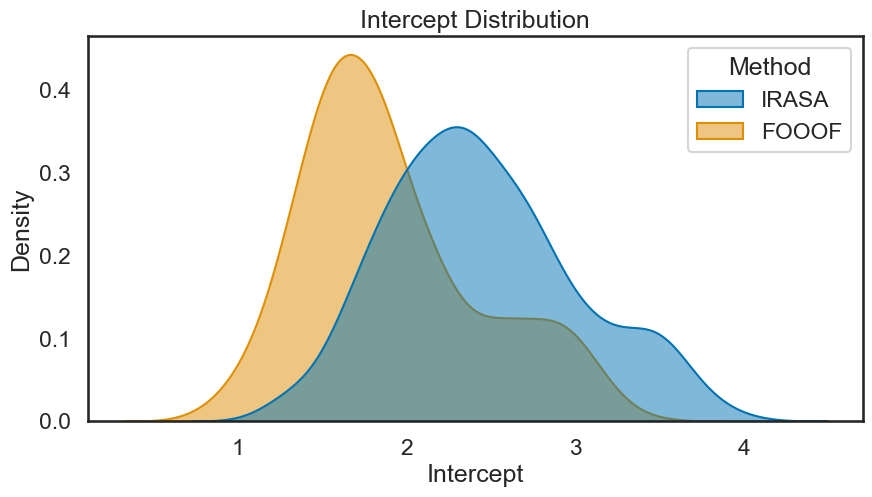

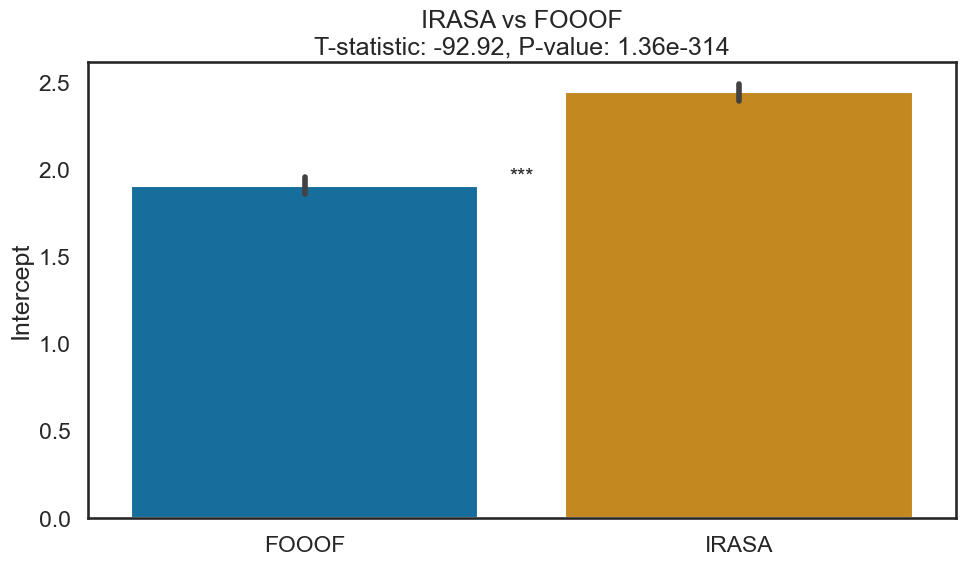

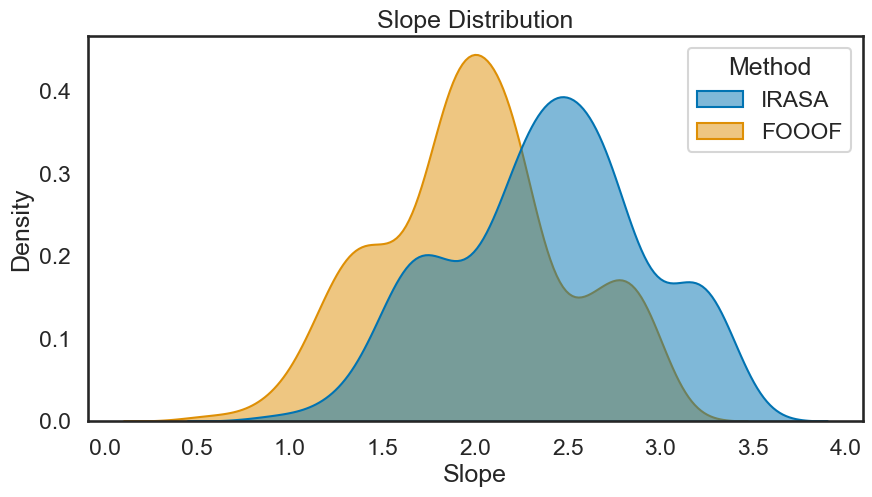

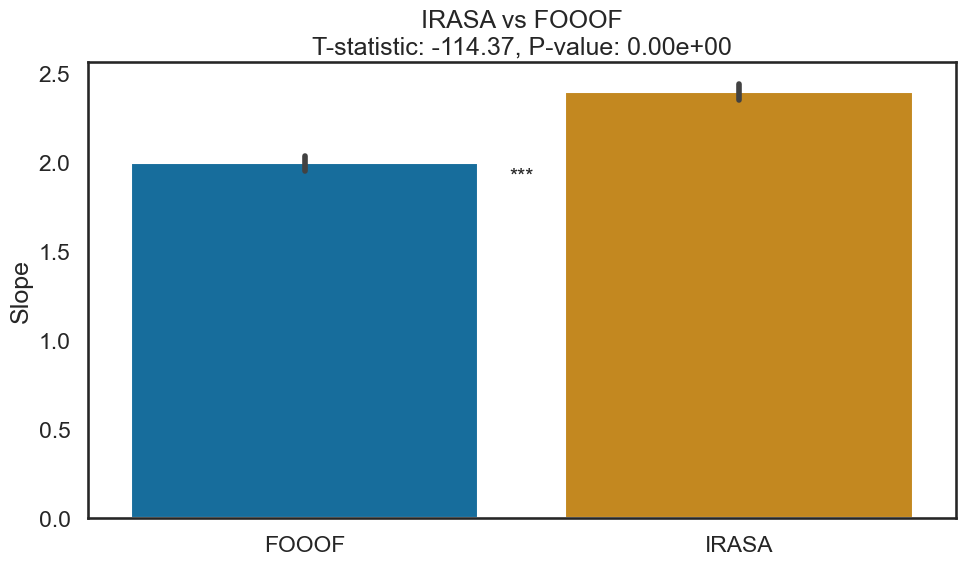

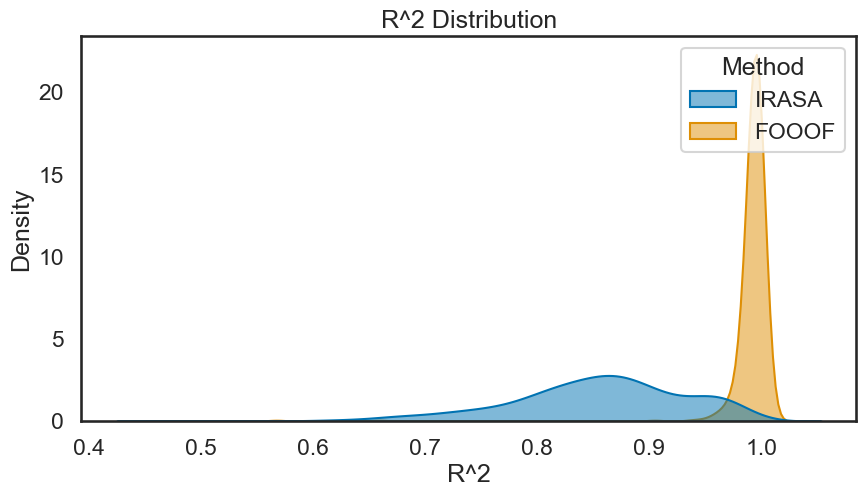

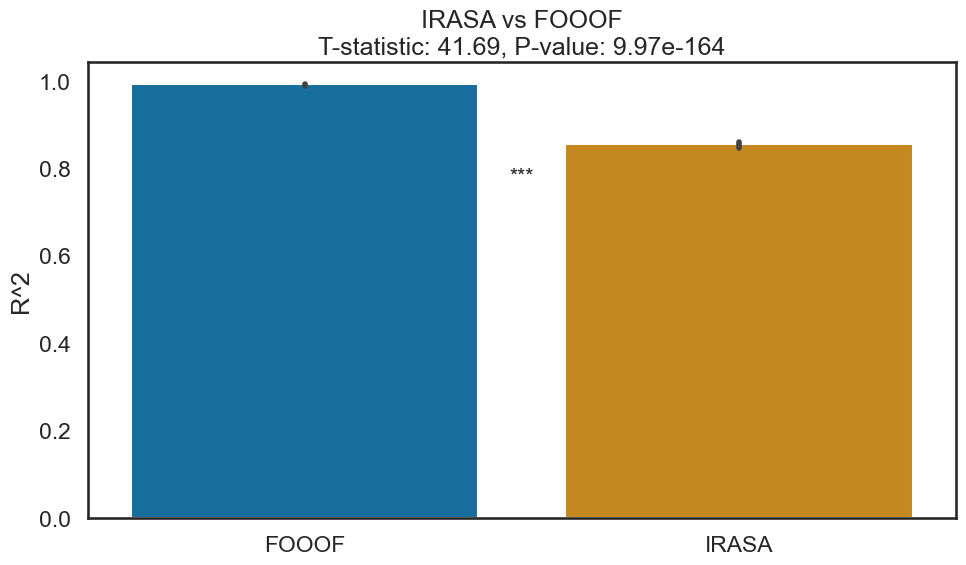

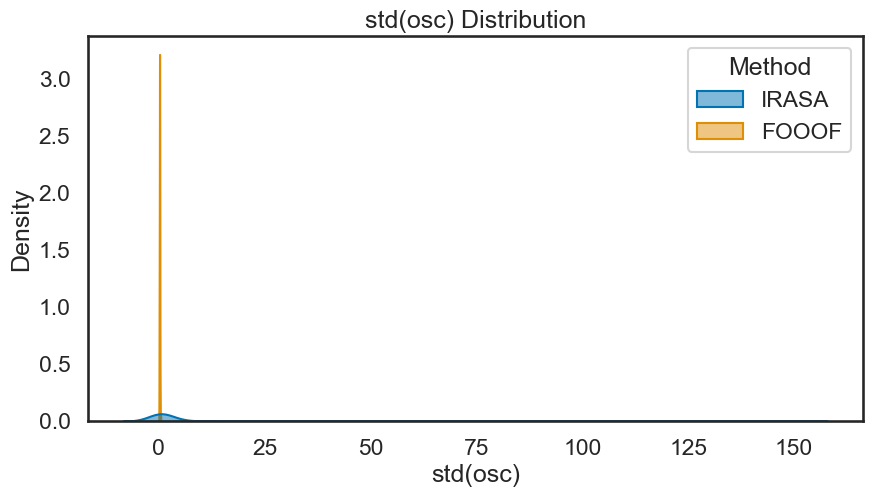

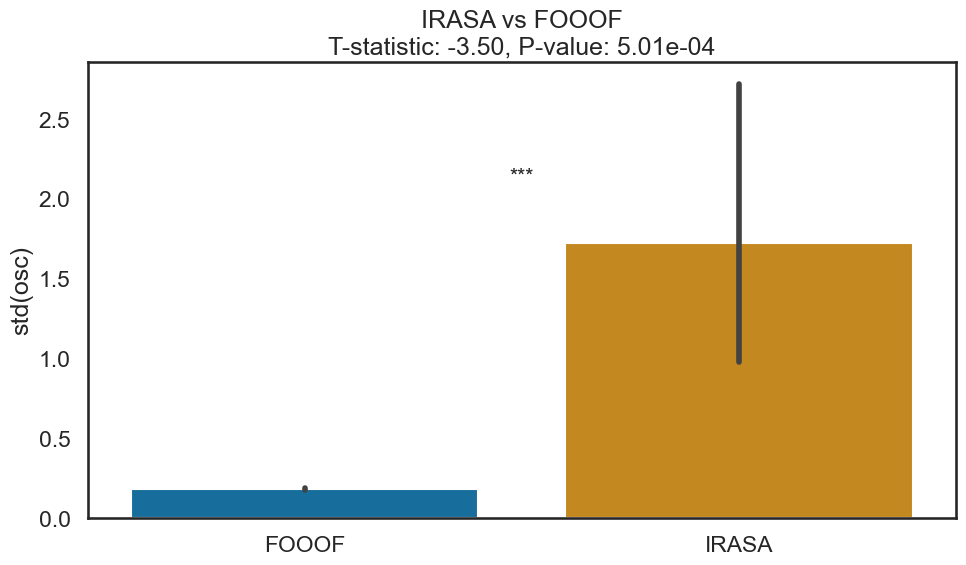

In [167]:
# Plot distributions with correlations
for param in ['Intercept', 'Slope', 'R^2', 'std(osc)']:
    # Plot distributions
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x=param, hue='Method', fill=True, alpha=0.5)
    plt.xlabel(f'{param}')
    plt.ylabel('Density')
    plt.title(f'{param} Distribution')
    corr = df_pivot[(param, 'FOOOF')].corr(df_pivot[(param, 'IRASA')], method='spearman')
    print(f'Correlation between IRASA and FOOOF for {param}: {corr.round(4)}')
    plt.savefig(f'{fig_path}{param}_distribution.png')
    # compute ttest between IRASA and FOOOF for each parameter
    t_stat, p_val = stats.ttest_rel(df_pivot[(param, 'FOOOF')], df_pivot[(param, 'IRASA')])
    print(f'T-test between IRASA and FOOOF for {param}: {t_stat} {p_val}')
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(data=[df_pivot[(param, 'FOOOF')], 
                      df_pivot[(param, 'IRASA')]])
    plt.xticks([0, 1], ['FOOOF','IRASA'])
    plt.title(f'IRASA vs FOOOF\nT-statistic: {t_stat:.2f}, P-value: {p_val:.2e}')
    plt.ylabel(f'{param}')
    
    # Add asterisk for significance
    if p_val < 0.001:
        significance = '***'
    elif p_val < 0.01:
        significance = '**'
    elif p_val < 0.05:
        significance = '*'
    else:
        significance = 'n.s.'

    # Place the significance level on the plot
    plt.text(0.5, .75, significance, ha='center', va='center', transform=plt.gca().transAxes, fontsize=15)

    plt.tight_layout()


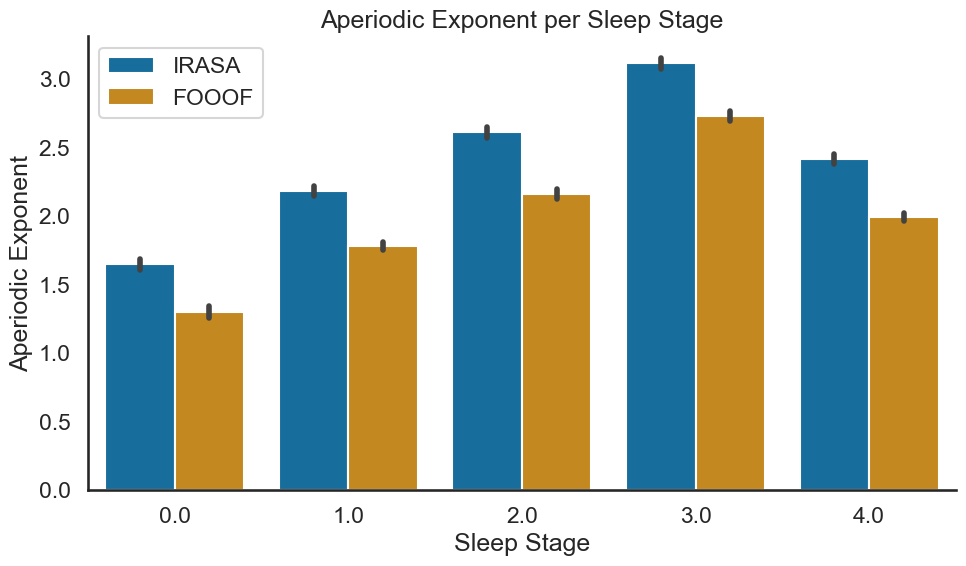

In [36]:
# Plot the aperiodic exponent for each sleep stage
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df, x='Stage', y='Slope', hue='Method', ax=ax)
#sns.swarmplot(data=df, x='Stage', y='Slope', hue='Method', dodge=True, ax=ax)
ax.set_xlabel('Sleep Stage')
ax.set_ylabel('Aperiodic Exponent')
ax.set_title('Aperiodic Exponent per Sleep Stage')
ax.legend(loc='upper left')
sns.despine()
plt.tight_layout()

### 6. Plot final fits with average aperiodic component

In [145]:
fit_df_all

,Chan,Intercept,Slope,R^2,std(osc),Stage,Subject,Method
0,C3,1.654351,-1.567869,0.759735,0.147302,0.0,802709,IRASA
1,C4,1.599429,-1.539321,0.755962,0.136412,0.0,802709,IRASA
2,C3,1.962980,-2.200121,0.858056,0.138081,1.0,802709,IRASA
3,C4,1.856123,-2.172328,0.851392,0.155589,1.0,802709,IRASA
4,C3,2.582385,-2.726470,0.898456,0.243379,2.0,802709,IRASA
...,...,...,...,...,...,...,...,...
5,C4,3.006744,-2.822934,0.910872,0.640189,2.0,800151,IRASA
6,C3,3.668662,-3.209198,0.975153,10.127701,3.0,800151,IRASA
7,C4,3.800273,-3.282055,0.976122,13.162280,3.0,800151,IRASA
8,C3,2.561284,-2.631069,0.889156,0.322501,4.0,800151,IRASA


/tmp/ipykernel_437035/1620377524.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median()
/tmp/ipykernel_437035/1620377524.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median()
/tmp/ipykernel_437035/1620377524.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median()
/tmp/ipykernel_437035/1620377524.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median()
/tmp/ipykernel_437035/1620377524.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median()
/tmp/ipykernel_43703

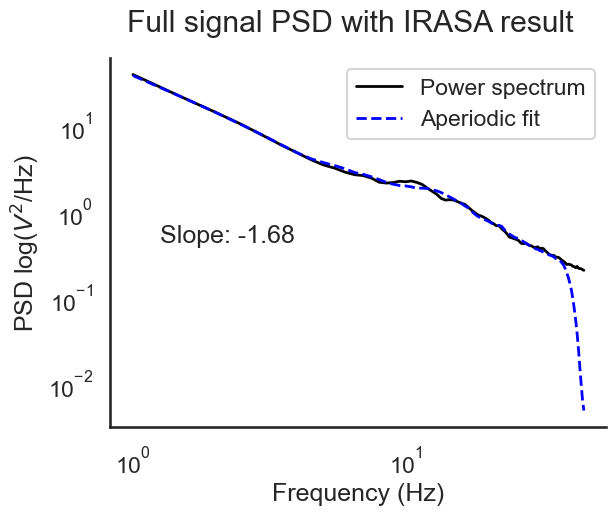

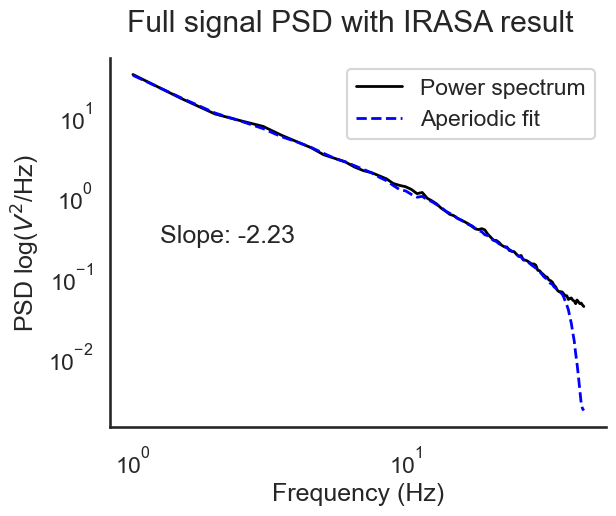

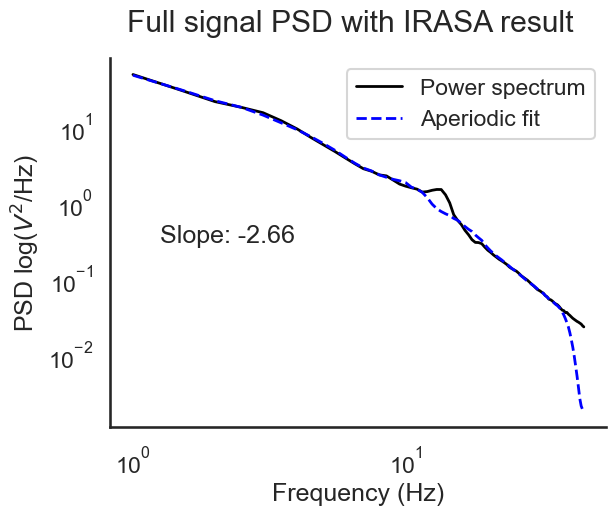

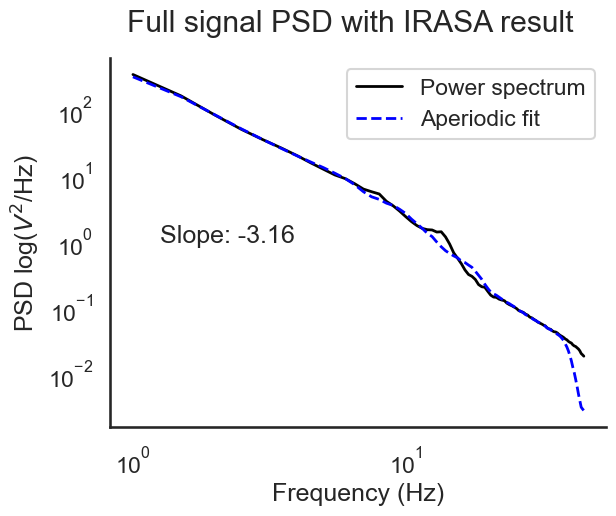

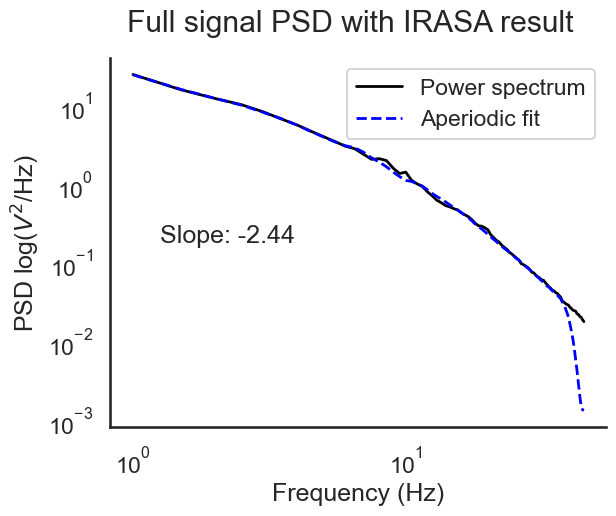

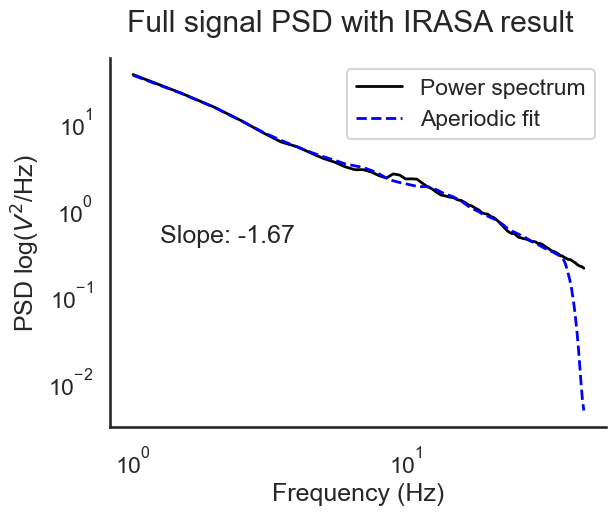

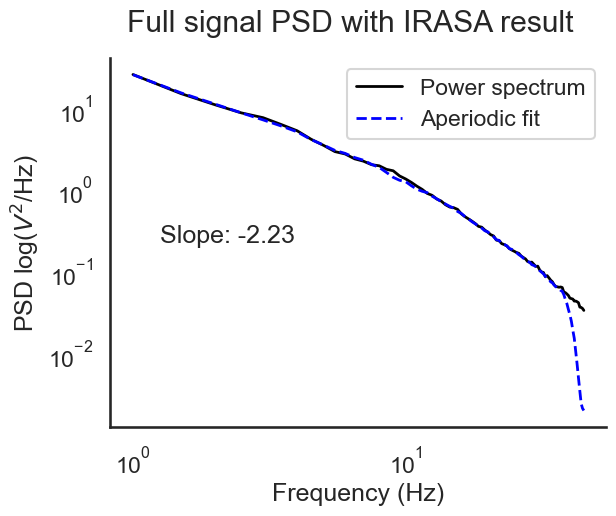

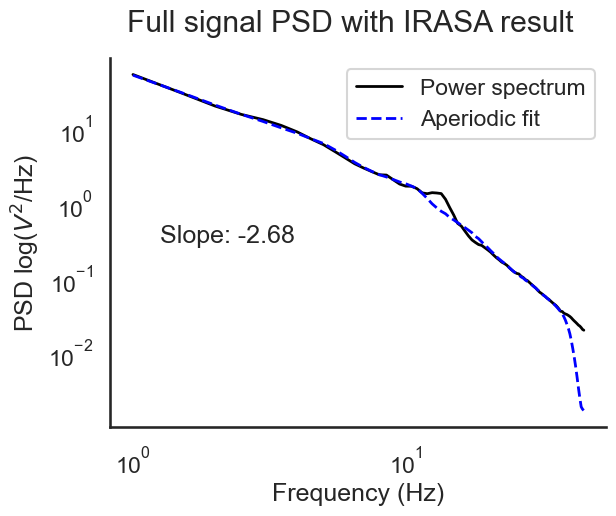

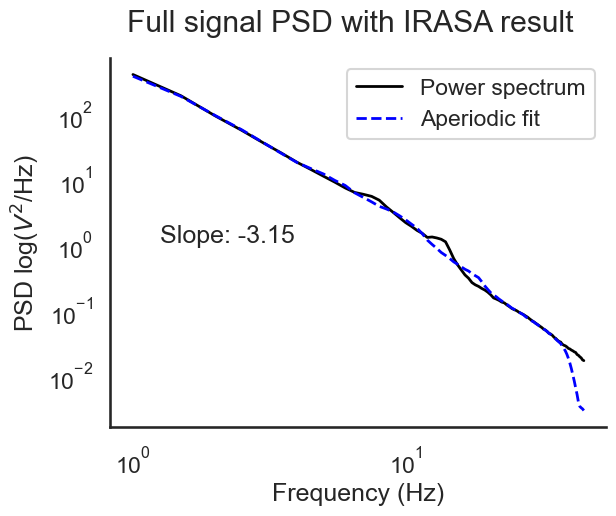

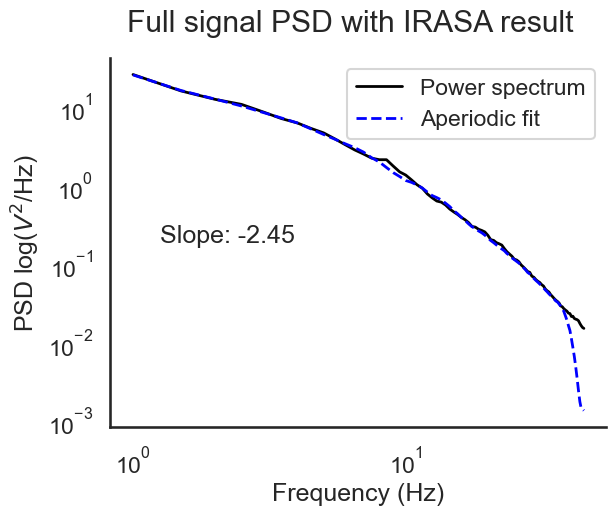

In [169]:
for chan in ['C3', 'C4']:
    for stage in [0, 1, 2, 3, 4]:
        fit_params = fit_df_all
        psd_ap = np.median([psd_aperiodic_all[idx][(stage, chan)] for idx in range(len(psd_aperiodic_all[idx]))], axis=0)
        psd_osc = np.median([psd_oscillatory_all[idx][(stage, chan)] for idx in range(len(psd_oscillatory_all[idx]))], axis=0)

        # Plot IRASA results
        fig = plt.figure() 
        plt.tight_layout()
        plt.yscale('log')
        plt.xscale('log')
        plt.plot(freqs, (psd_ap+psd_osc).ravel(), c='k', label="Power spectrum", lw=2)
        plt.plot(freqs, psd_ap.ravel(), c='b',linestyle='--', label="Aperiodic fit", lw=2)
        #plt.plot(freqs, psd_osc.ravel(), c='cyan',linestyle='--', label="Periodic components", lw=2)
        fig.suptitle('Full signal PSD with IRASA result')
        fig.axes[0].set_xlabel("Frequency (Hz)")
        fig.axes[0].set_ylabel("PSD log($V^2$/Hz)")
        fig.axes[0].legend()
        # set text with fit parameters 
        slope = fit_params.set_index(['Chan','Stage']).loc[chan, stage]['Slope'].median()
        fig.axes[0].text(0.1, 0.5, f"Slope: {round(slope,2)}",
                        transform=fig.axes[0].transAxes)    
        sns.despine()   

In [50]:
C3_Wake = combine_fooofs([fooof_groups_all[sub_idx][(0, 'C3')] for sub_idx in range(0, 10)])
C4_Wake = combine_fooofs([fooof_groups_all[sub_idx][(0, 'C4')] for sub_idx in range(0, 10)])
C3_N1 = combine_fooofs([fooof_groups_all[sub_idx][(1, 'C3')] for sub_idx in range(0, 10)])
C4_N1 = combine_fooofs([fooof_groups_all[sub_idx][(1, 'C4')] for sub_idx in range(0, 10)])
C3_N2 = combine_fooofs([fooof_groups_all[sub_idx][(2, 'C3')] for sub_idx in range(0, 10)])
C4_N2 = combine_fooofs([fooof_groups_all[sub_idx][(2, 'C4')] for sub_idx in range(0, 10)])
C3_N3 = combine_fooofs([fooof_groups_all[sub_idx][(3, 'C3')] for sub_idx in range(0, 10)])
C4_N3 = combine_fooofs([fooof_groups_all[sub_idx][(3, 'C4')] for sub_idx in range(0, 10)])
C3_REM = combine_fooofs([fooof_groups_all[sub_idx][(4, 'C3')] for sub_idx in range(0, 10)])
C4_REM = combine_fooofs([fooof_groups_all[sub_idx][(4, 'C4')] for sub_idx in range(0, 10)])

/home/administrator/anaconda3/envs/NDS/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


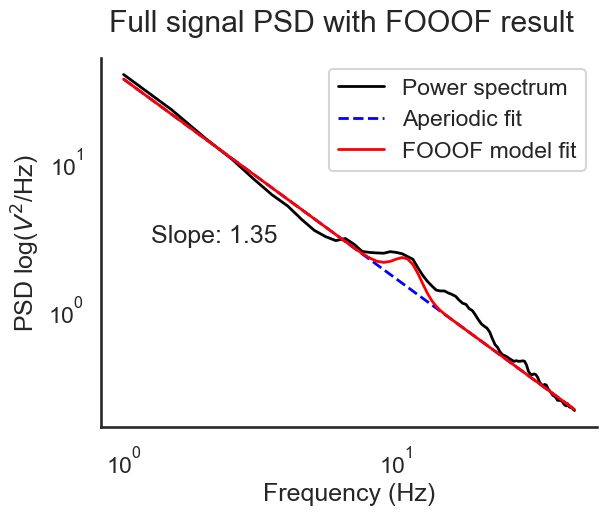

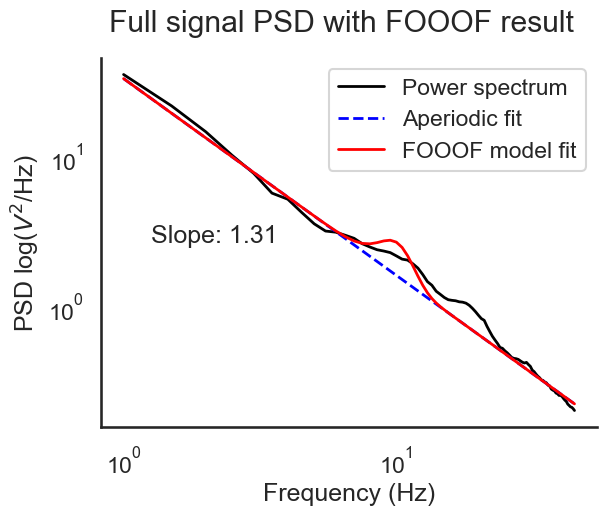

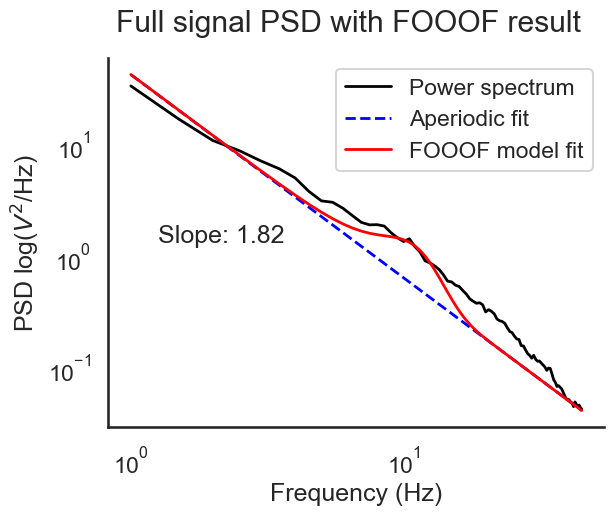

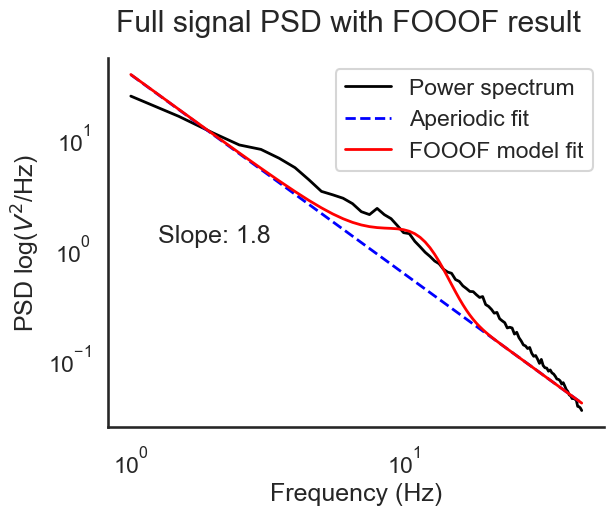

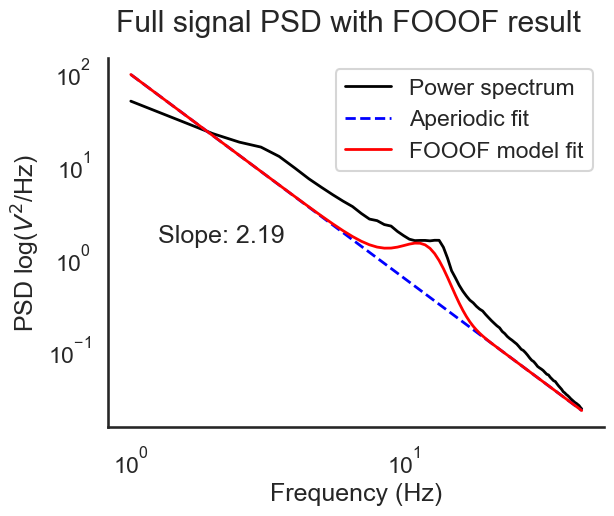

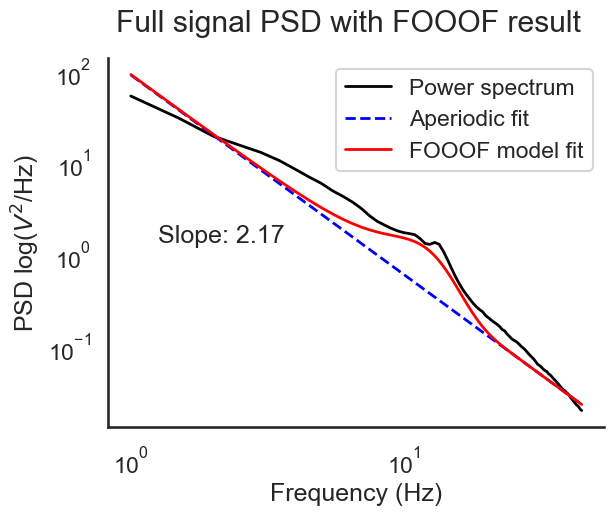

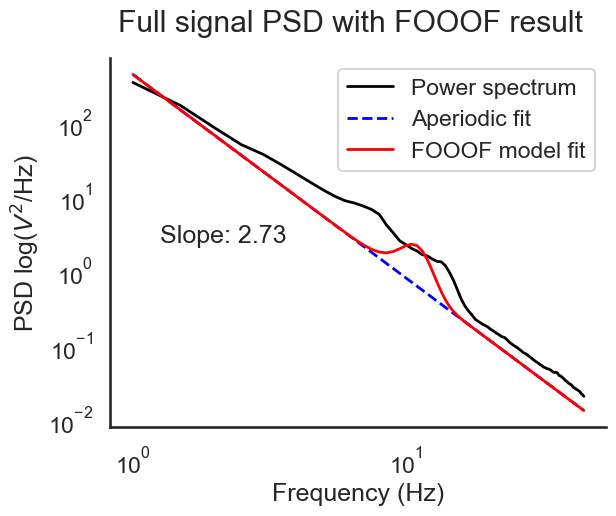

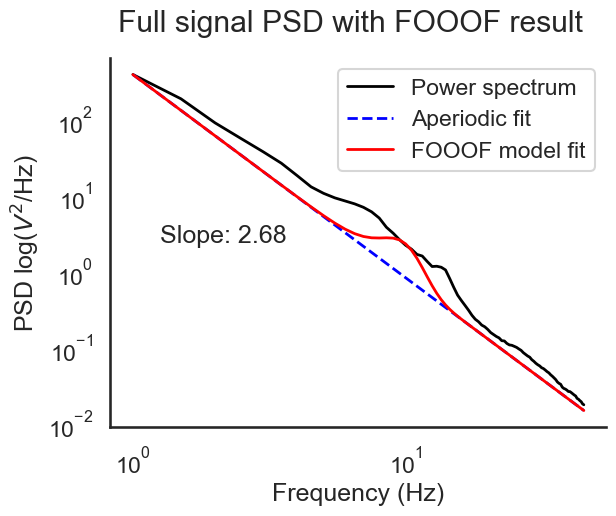

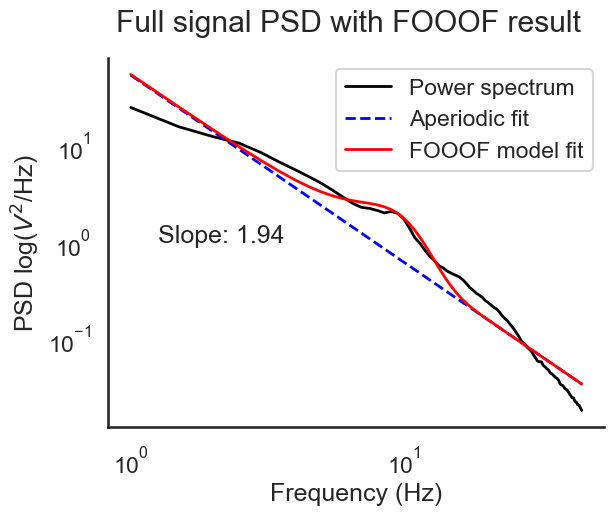

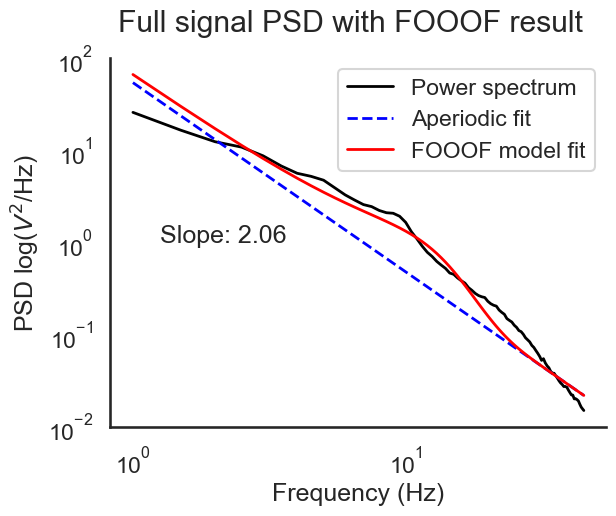

In [107]:
for obj in [C3_Wake, C4_Wake, C3_N1, C4_N1, C3_N2, C4_N2, C3_N3, C4_N3, C3_REM, C4_REM]:
    bands = Bands({'Broadband': [1, 45]})
    # Average across individual models fits, specifying bands and an averaging function
    afm = average_fg(obj, bands, avg_method='median')
    # Plot FOOOF results
    fig = plt.figure() 
    plt.tight_layout()
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(afm.freqs, 10**(np.median(obj.power_spectra, 0)), c='k', label="Power spectrum", lw=2)
    plt.plot(afm.freqs, 10**(afm._ap_fit), c='b',linestyle='--', label="Aperiodic fit", lw=2)
    plt.plot(afm.freqs, 10**(afm.fooofed_spectrum_), c='r', label="FOOOF model fit", lw=2)
    fig.suptitle('Full signal PSD with FOOOF result')
    fig.axes[0].set_xlabel("Frequency (Hz)")
    fig.axes[0].set_ylabel("PSD log($V^2$/Hz)")
    fig.axes[0].legend()
    # set text with fit parameters
    fig.axes[0].text(0.1, 0.5, f"Slope: {round(afm.aperiodic_params_[1], 2)}", 
                    transform=fig.axes[0].transAxes)
    sns.despine()

In [27]:
def foi_range_irasa(foi=(1,45), hset_max=1.9):
    """

    Calculate the frequency range to evaluate the IRASA power spectrum.

    Parameters
    ----------
    foi : tuple of int or float
        Frequency range of interest.
    hset_max : float
        Maximum resampling factor.

    """

    freq_eval_min = foi[0] / hset_max
    freq_eval_max = foi[1] * hset_max

    return freq_eval_min, freq_eval_max

#freq_min, freq_max = foi_range_irasa(foi=(1,30), hset_max=1.5)
#freq_min, freq_max

(0.6666666666666666, 45.0)

In [ ]:
psd_aperiodic_all
psd_oscillatory_all

In [37]:
fooof_groups_all

[{(0.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6baa4610>,
  (0.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6b9d5660>,
  (1.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6b880790>,
  (1.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6b8807c0>,
  (2.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6b99b400>,
  (2.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6b998640>,
  (3.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6b999120>,
  (3.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6b998a00>,
  (4.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6b9999f0>,
  (4.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6b999c60>},
 {(0.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6bcfca30>,
  (0.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6bcff7c0>,
  (1.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6bcfc460>,
  (1.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6bcff610>,
  (2.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6bd368f0>,
  (2.0, 'C4'): <fooof.objs.fit.FOOOF at 0x7f0c6bd36a40>,
  (3.0, 'C3'): <fooof.objs.fit.FOOOF at 0x7f0c6bd35d20>,
  (3.0, 'C4'): <fooof.objs.fit